# Single Layer Unidirectional LSTM Model using word2vec

In [67]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D, Embedding, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [3]:
df_train = pd.read_csv("train_data.csv")
df_train.head()

,processed_tweet,tweet_length,word_count,avg_word_length,exclamation_count,uppercase_ratio,hashtag_count,positive_word_count,negative_word_count,sentiment_score,sentiment,sentiment_label
0,country committed atrocious act physical cultu...,202,28,7.214286,0,0.019802,3,0,0,0,0,Mild_Neg
1,prairietara google itâ convoy represents freed...,251,41,6.121951,0,0.019920,0,0,0,0,4,Strong_Pos
2,freedom convoy 2022 toronto convoie de la libe...,86,11,7.818182,0,0.069767,2,0,0,0,4,Strong_Pos
3,america january 6th political prisoner canada ...,140,22,6.363636,0,0.042857,0,0,0,0,0,Mild_Neg
4,ctvnews russian bot triggered,50,8,6.250000,0,0.100000,0,0,0,0,2,Neutral


In [4]:
df_test = pd.read_csv("test_data.csv")
df_test.head()

,processed_tweet,tweet_length,word_count,avg_word_length,exclamation_count,uppercase_ratio,hashtag_count,positive_word_count,negative_word_count,sentiment_score,sentiment,sentiment_label
0,mk3telford ctvnews people ottawa .. largely wa...,107,17,6.294118,0,0.074766,0,0,0,0,3,Strong_Neg
1,canada crisis justin trudeau invoked emergency...,278,29,9.586207,0,0.129496,7,0,0,0,3,Strong_Neg
2,johngatti2 chickengate learning happened freed...,99,14,7.071429,0,0.040404,0,0,0,0,4,Strong_Pos
3,unicorn6610 kidsbookartist muskoka think essen...,177,25,7.080000,0,0.033898,0,0,0,0,2,Neutral
4,thanks pn_news_en buperac yesterday freedomcon...,290,31,9.354839,1,0.100000,21,0,0,0,1,Mild_Pos


In [5]:
df_train.shape

(361051, 12)

In [6]:
df_test.shape

(90263, 12)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361051 entries, 0 to 361050
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   processed_tweet      361051 non-null  object 
 1   tweet_length         361051 non-null  int64  
 2   word_count           361051 non-null  int64  
 3   avg_word_length      361051 non-null  float64
 4   exclamation_count    361051 non-null  int64  
 5   uppercase_ratio      361051 non-null  float64
 6   hashtag_count        361051 non-null  int64  
 7   positive_word_count  361051 non-null  int64  
 8   negative_word_count  361051 non-null  int64  
 9   sentiment_score      361051 non-null  int64  
 10  sentiment            361051 non-null  int64  
 11  sentiment_label      361051 non-null  object 
dtypes: float64(2), int64(8), object(2)
memory usage: 33.1+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90263 entries, 0 to 90262
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   processed_tweet      90263 non-null  object 
 1   tweet_length         90263 non-null  int64  
 2   word_count           90263 non-null  int64  
 3   avg_word_length      90263 non-null  float64
 4   exclamation_count    90263 non-null  int64  
 5   uppercase_ratio      90263 non-null  float64
 6   hashtag_count        90263 non-null  int64  
 7   positive_word_count  90263 non-null  int64  
 8   negative_word_count  90263 non-null  int64  
 9   sentiment_score      90263 non-null  int64  
 10  sentiment            90263 non-null  int64  
 11  sentiment_label      90263 non-null  object 
dtypes: float64(2), int64(8), object(2)
memory usage: 8.3+ MB


In [9]:
sentences = [tweet.split() for tweet in pd.concat([df_train, df_test])['processed_tweet']]

In [10]:
word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4, sg=1, epochs=20)

In [11]:
EMBEDDING_DIM = 200
LSTM_UNITS = 128
DENSE_UNITS = 64
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
EPOCHS = 10

In [12]:
tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['processed_tweet'])
word_index = tokenizer.word_index

In [13]:
embedding_matrix = np.zeros((min(30000, len(word_index))+1, 200))
for word, i in tokenizer.word_index.items():
    if i < 30000 and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [14]:
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['processed_tweet']), maxlen=120, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['processed_tweet']), maxlen=120, padding='post', truncating='post')

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment_label'])
y_test = le.transform(df_test['sentiment_label'])
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [16]:
model = Sequential([
    Embedding(input_dim=min(30000, len(word_index)+1),output_dim=EMBEDDING_DIM,input_length=120,mask_zero=True),
    SpatialDropout1D(DROPOUT_RATE),
    Bidirectional(LSTM(LSTM_UNITS,return_sequences=True,dropout=DROPOUT_RATE,recurrent_dropout=RECURRENT_DROPOUT,kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Bidirectional(LSTM(LSTM_UNITS//2,dropout=DROPOUT_RATE,recurrent_dropout=RECURRENT_DROPOUT,kernel_regularizer=l2(0.001))),
    Dense(DENSE_UNITS, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(DROPOUT_RATE),
    Dense(y_train.shape[1], activation='softmax')])

C:\Users\srida\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [19]:
history = model.fit(X_train, y_train,batch_size=256,epochs=10,validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)],
    class_weight=class_weights,verbose=1)

Epoch 1/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2639s 2s/step - accuracy: 0.4621 - loss: 2.1137 - val_accuracy: 0.7033 - val_loss: 1.0531 - learning_rate: 5.0000e-04
Epoch 2/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2346s 2s/step - accuracy: 0.6942 - loss: 1.1078 - val_accuracy: 0.7324 - val_loss: 0.8597 - learning_rate: 5.0000e-04
Epoch 3/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2372s 2s/step - accuracy: 0.7313 - loss: 0.9196 - val_accuracy: 0.7301 - val_loss: 0.8259 - learning_rate: 5.0000e-04
Epoch 4/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2412s 2s/step - accuracy: 0.7502 - loss: 0.8333 - val_accuracy: 0.7279 - val_loss: 0.8108 - learning_rate: 5.0000e-04
Epoch 5/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2398s 2s/step - accuracy: 0.7617 - loss: 0.7897 - val_accuracy: 0.7457 - val_loss: 0.7640 - learning_rate: 5.0000e-04
Epoch 6/10
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2462s 2s/step - accuracy: 0.7728 - loss: 0.7475 - val_accuracy: 0.7300 - val_loss: 0.8009 - learning_rate: 5.0000e-04
Epoch 7/10
1411/1411 ━━━━━━━━━━━━━━━━━━━

## Training Evaluation Metrics

In [116]:
print("Your class names:", le.classes_)

Your class names: ['Mild_Neg' 'Mild_Pos' 'Neutral' 'Strong_Neg' 'Strong_Pos']


In [118]:
y_train_classes = np.argmax(y_train, axis=1)

In [120]:
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

11283/11283 ━━━━━━━━━━━━━━━━━━━━ 472s 42ms/step


### Confusion Matrix


=== TRAINING DATA ===


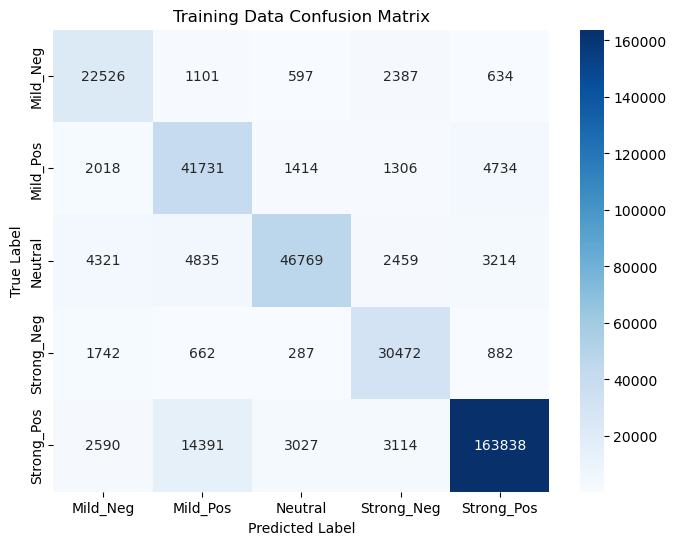

In [122]:
print("\n=== TRAINING DATA ===")
plt.figure(figsize=(8,6))
cm_train = confusion_matrix(y_train_classes, y_train_pred_classes)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Training Data Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification report

In [124]:
report_train = classification_report(y_train_classes, y_train_pred_classes, target_names=le.classes_,output_dict=True)

In [125]:
print("\nTraining F1 Scores:")
for cls in le.classes_:
    print(f"{cls}: {report_train[cls]['f1-score']:.4f}")


Training F1 Scores:
Mild_Neg: 0.7454
Mild_Pos: 0.7326
Neutral: 0.8227
Strong_Neg: 0.8260
Strong_Pos: 0.9095


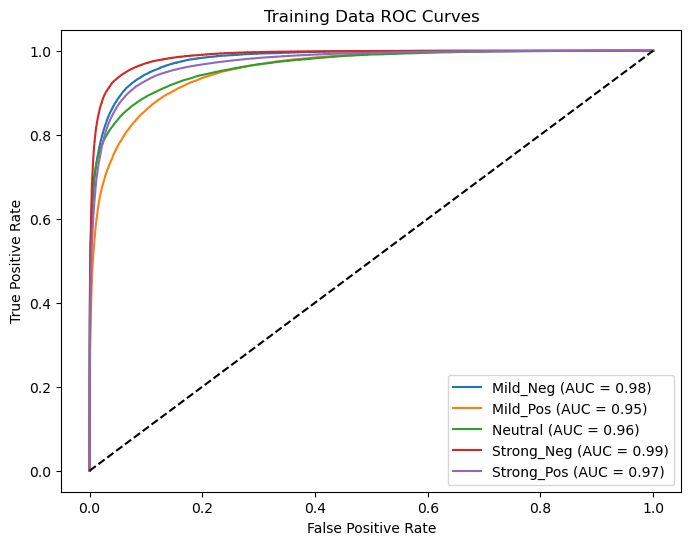

In [126]:
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_train[:, i], y_train_pred[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_score(y_train[:, i], y_train_pred[:, i]):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Data ROC Curves')
plt.legend()
plt.show()

In [127]:
auc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
print(f"\nTraining AUC Score: {auc_train:.4f}")


Training AUC Score: 0.9716


In [128]:
print("\nTraining Classification Report:")
print(classification_report(y_train_classes, y_train_pred_classes, target_names=le.classes_))


Training Classification Report:
              precision    recall  f1-score   support

    Mild_Neg       0.68      0.83      0.75     27245
    Mild_Pos       0.67      0.82      0.73     51203
     Neutral       0.90      0.76      0.82     61598
  Strong_Neg       0.77      0.90      0.83     34045
  Strong_Pos       0.95      0.88      0.91    186960

    accuracy                           0.85    361051
   macro avg       0.79      0.83      0.81    361051
weighted avg       0.86      0.85      0.85    361051



In [129]:
accuracy_train = accuracy_score(y_train_classes, y_train_pred_classes)
print(f"\nTraining Accuracy: {accuracy_train:.4f}")


Training Accuracy: 0.8457


## Test Evaluation Metrics

In [131]:
y_test_classes = np.argmax(y_test, axis=1)

In [132]:
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

2821/2821 ━━━━━━━━━━━━━━━━━━━━ 115s 41ms/step


### Confusion matrix


=== TESTING DATA ===


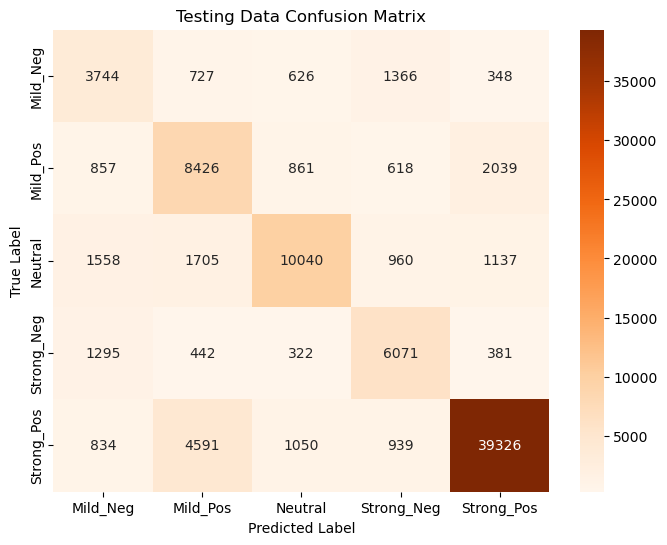

In [134]:
print("\n=== TESTING DATA ===")
plt.figure(figsize=(8,6))
cm_test = confusion_matrix(y_test_classes, y_test_pred_classes)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Testing Data Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification report

In [136]:
report_test = classification_report(y_test_classes, y_test_pred_classes, target_names=le.classes_,output_dict=True)

In [137]:
print("\nTesting F1 Scores:")
for cls in le.classes_:
    print(f"{cls}: {report_test[cls]['f1-score']:.4f}")


Testing F1 Scores:
Mild_Neg: 0.4959
Mild_Pos: 0.5873
Neutral: 0.7096
Strong_Neg: 0.6576
Strong_Pos: 0.8742


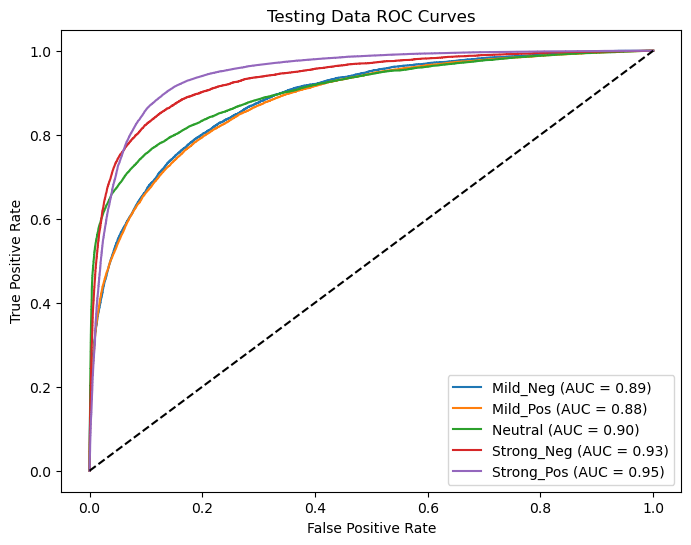

In [138]:
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_score(y_test[:, i], y_test_pred[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Data ROC Curves')
plt.legend()
plt.show()

In [139]:
auc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
print(f"\nTesting AUC Score: {auc_test:.4f}")


Testing AUC Score: 0.9099


In [140]:
print("\nTesting Classification Report:")
print(classification_report(y_test_classes, y_test_pred_classes, target_names=le.classes_))


Testing Classification Report:
              precision    recall  f1-score   support

    Mild_Neg       0.45      0.55      0.50      6811
    Mild_Pos       0.53      0.66      0.59     12801
     Neutral       0.78      0.65      0.71     15400
  Strong_Neg       0.61      0.71      0.66      8511
  Strong_Pos       0.91      0.84      0.87     46740

    accuracy                           0.75     90263
   macro avg       0.66      0.68      0.66     90263
weighted avg       0.77      0.75      0.76     90263



In [141]:
accuracy_test = accuracy_score(y_test_classes, y_test_pred_classes)
print(f"\nTesting Accuracy: {accuracy_test:.4f}")


Testing Accuracy: 0.7490
